# SMS data

# Loading data

In [5]:
import pandas as pd

sms = pd.read_csv("data/sms_train.csv", sep=',')
sms.columns = ['label', 'message']
X_test = pd.read_csv("data/sms_test.csv", sep=',')
X_test.columns = ['message']

In [6]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        3959   3730                             Sorry, I'll call later   26
1         613    552  Please call our customer service representativ...    4

Training dataset is not balanced - balanced accuracy score will be helpful here.

### Counting words

Only train set is used for counting words. Adding validation set would include bias in accuracies obtained later.

This is why only 7000 words are found. If the validation was added too, there would be more words (close to 7879 as in the task description).

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(sms['message'], sms['label'], test_size=0.2, random_state=0)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)
word_to_id_df = pd.DataFrame([{'label':k, 'id':i} for k, i in vect.vocabulary_.items()])
word_to_id_df = word_to_id_df.sort_values(by='id').reset_index(drop=True)
def encode_dataset(X, words_to_ids):
    X_transformed = vect.transform(X)
    X_encoded = pd.DataFrame(X_transformed.toarray(), columns=words_to_ids['label'])
    X_encoded.columns.name = ''
    return X_encoded
X_train_encoded = encode_dataset(X_train, word_to_id_df)
X_valid_encoded = encode_dataset(X_valid, word_to_id_df)
X_test_encoded = encode_dataset(X_test['message'], word_to_id_df)

In [22]:
X_train_encoded.shape # around 7000 columns

(3657, 7021)

In [23]:
X_train_encoded.head(2)

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,02,0207,...,zebra,zed,zhong,zindgi,zoe,zogtorius,zoom,zyada,ú1,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature selection

## Boruta

In [24]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=7, random_state=42, class_weight='balanced', n_jobs=-1)
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=42, verbose=0)
import numpy as np
np.int = int
np.float = float
np.bool = bool
feat_selector.fit(X_train_encoded.values, y_train)
print(f'Number of features selected: {feat_selector.n_features_}')
X_train_filtered = feat_selector.transform(X_train_encoded.values)
X_valid_filtered = feat_selector.transform(X_valid_encoded.values)
X_test_filtered = feat_selector.transform(X_test_encoded.values)

Number of features selected: 159


In [25]:
# print names of selected features
selected_features = X_train_encoded.columns[feat_selector.support_].values.tolist()
print(f'Selected {len(selected_features)} features: {selected_features}')

Selected 159 features: ['000', '08000839402', '10', '100', '1000', '10p', '150p', '150ppm', '16', '18', '1st', '2000', '50', '500', '5000', '8007', '86688', '87066', 'and', 'apply', 'at', 'await', 'award', 'awarded', 'bonus', 'box', 'but', 'call', 'camera', 'can', 'cash', 'chance', 'chat', 'claim', 'co', 'code', 'collection', 'colour', 'com', 'come', 'contact', 'cost', 'cs', 'customer', 'dating', 'do', 'double', 'draw', 'entry', 'every', 'find', 'for', 'free', 'freemsg', 'from', 'games', 'get', 'going', 'got', 'gt', 'guaranteed', 'has', 'have', 'he', 'holiday', 'home', 'hot', 'how', 'http', 'if', 'in', 'is', 'it', 'its', 'land', 'landline', 'later', 'latest', 'like', 'line', 'live', 'll', 'love', 'lt', 'ltd', 'me', 'min', 'mins', 'mob', 'mobile', 'msg', 'my', 'national', 'network', 'new', 'nokia', 'not', 'now', 'number', 'offer', 'offers', 'ok', 'on', 'only', 'or', 'orange', 'our', 'out', 'per', 'pics', 'please', 'po', 'poly', 'prize', 'quiz', 'rate', 'receive', 'reply', 'reveal', 'rin

### Naive Bayes vs correlation threshold

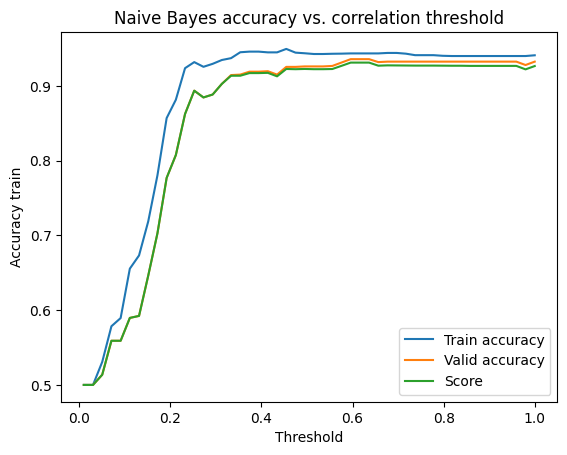

Best threshold: 0.6161


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB

def get_accuracy_for_threshold(threshold):

    corr_matrix = pd.DataFrame(X_train_filtered, columns=selected_features).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    X_train_filtered_small = pd.DataFrame(X_train_filtered, columns=selected_features).drop(to_drop, axis=1)
    X_valid_filtered_small = pd.DataFrame(X_valid_filtered, columns=selected_features).drop(to_drop, axis=1)

    nb = MultinomialNB()
    nb.fit(X_train_filtered_small, y_train)
    y_pred_train = nb.predict(X_train_filtered_small)
    balanced_acc_train = balanced_accuracy_score(y_train, y_pred_train)
    y_pred_valid = nb.predict(X_valid_filtered_small)
    balanced_acc_valid = balanced_accuracy_score(y_valid, y_pred_valid)
    score = balanced_acc_valid - 0.01 * max(X_train_filtered_small.shape[1] / 100 - 1, 0)

    return {'Threshold': threshold, 'Accuracy train': balanced_acc_train, 'Accuracy valid': balanced_acc_valid, 'Score': score}

thresholds = np.linspace(0.01, 1, 50)
results = pd.DataFrame([get_accuracy_for_threshold(t) for t in thresholds])
sns.lineplot(x='Threshold', y='Accuracy train', data=results, label='Train accuracy')
sns.lineplot(x='Threshold', y='Accuracy valid', data=results, label='Valid accuracy')
sns.lineplot(x='Threshold', y='Score', data=results, label='Score')
plt.title('Naive Bayes accuracy vs. correlation threshold')
plt.show()

print(f'Best threshold: {results.sort_values(by="Score", ascending=False).iloc[0]["Threshold"]:0.4f}')

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

best_threshold = results.sort_values(by="Score", ascending=False).iloc[0]["Threshold"]
corr_matrix = pd.DataFrame(X_train_filtered, columns=selected_features).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > best_threshold)]
X_train_filtered_small = pd.DataFrame(X_train_filtered, columns=selected_features).drop(to_drop, axis=1)
X_valid_filtered_small = pd.DataFrame(X_valid_filtered, columns=selected_features).drop(to_drop, axis=1)
X_test_filtered_small = pd.DataFrame(X_test_filtered, columns=selected_features).drop(to_drop, axis=1)
print(f'Number of features after dropping: {X_train_filtered_small.shape[1]}')
selected_features_final = X_train_filtered_small.columns.values.tolist()
print(f'Features after filtering: {selected_features_final}')

nb = MultinomialNB()
nb.fit(X_train_filtered_small, y_train)
y_pred_train = nb.predict(X_train_filtered_small)
balanced_acc_train = balanced_accuracy_score(y_train, y_pred_train)
y_pred_valid = nb.predict(X_valid_filtered_small)
balanced_acc_valid = balanced_accuracy_score(y_valid, y_pred_valid)
print(f'Balanced train accuracy score: {balanced_acc_train:.4f}')
print(f'Balanced validation accuracy  score: {balanced_accuracy_score(y_valid, y_pred):.4f}')


Number of features after dropping: 146
Features after filtering: ['000', '08000839402', '10', '100', '1000', '10p', '150p', '150ppm', '16', '18', '1st', '2000', '50', '500', '5000', '8007', '86688', '87066', 'and', 'apply', 'at', 'await', 'award', 'awarded', 'bonus', 'box', 'but', 'call', 'camera', 'can', 'cash', 'chance', 'chat', 'claim', 'co', 'code', 'colour', 'com', 'come', 'contact', 'cost', 'cs', 'customer', 'dating', 'do', 'draw', 'entry', 'every', 'find', 'for', 'free', 'freemsg', 'from', 'games', 'get', 'going', 'got', 'gt', 'guaranteed', 'has', 'have', 'he', 'home', 'hot', 'how', 'http', 'if', 'in', 'is', 'it', 'its', 'land', 'landline', 'later', 'latest', 'like', 'live', 'll', 'love', 'ltd', 'me', 'min', 'mins', 'mob', 'mobile', 'msg', 'my', 'national', 'network', 'new', 'nokia', 'not', 'now', 'number', 'offer', 'offers', 'ok', 'on', 'only', 'or', 'our', 'out', 'per', 'pics', 'please', 'poly', 'prize', 'quiz', 'receive', 'reply', 'reveal', 'ringtone', 'send', 'service', 'sho

# Saving predictions

In [ ]:
# save posterior probabilities to file
y_proba_01 = nb.predict_proba(X_test_filtered_small)
y_proba_1 = y_proba_01[:, 1]
df_y_proba_1 = pd.DataFrame(y_proba_1)
df_y_proba_1.to_csv('MACPAW_sms_prediction.csv', index=False, header=False)

# save feature names to file
with open('MACPAW_sms_features.txt', 'w') as f:
    for feature in selected_features_final:
        f.write(str(feature) + '\n')